
1.  Google Colabを開く。
2.  Kaggleからタイタニックのデータをアップロードする。
3.  Pythonでデータを読み込んで『表示』する。





In [2]:
#pandasライブラリをインポートして、pdで呼び出せるようにする
import pandas as pd

# 1. データを読み込む
# "pd.read_csv" は、CSVファイルを表形式で読み込む魔法です
#変数：dfにpandasライブラリのread_csvという関数を使ってファイルを読み込む
df = pd.read_csv("train.csv")
#Nameに含まれている敬称をもとに年齢の欠損地を埋める。
#名前から敬称を取り出し、新たに敬称列を作成
# str.extract(' ([A-Za-z]+)\.') は、「 .（ドット）の前にある単語」を抜き出す正規表現です
#df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.',expand=False)

#print("タイタニックの乗客データ（最初の５人）を表示")
#headは先頭５行を表示する
#df.head()

print("名前から取り出した「敬称」のリスト")
print(df['Title'].value_counts())
#考察
#やはり成人男性？(Mr)の数が圧倒的に多いのが見てわかる
#また、敬称以外も取り出してしまっていて、余計なデータも出力してしまっている
#->レアな敬称でした
#最終行付近はエラーメッセージのように見えるけど、正規表現とマッチしない行があったってことかな？
#->Geminiからの回答
#Pythonからのメッセージ
#『あのー、\. って書いてあるけど、これ "ドットそのもの" って意味でいいんだよね？ 特殊な記号と間違えやすいから、次からは r を付けて r'...' って書くと、誤解がなくて助かるな〜（チラッ）』

名前から取り出した「敬称」のリスト
Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


In [3]:
# 1. 似ている敬称をまとめる（表記ゆれを直す）
# replace(['古い名前', ...], '新しい名前') で置き換えます
#MlleとMsをMissに置換
df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss')
#MmeとLadyをMrsに置換
df['Title'] = df['Title'].replace(['Mme','Lady'],'Mrs')

# 2. 珍しい敬称（Dr, Rev, Sirなど）を全部「Rare」というグループにまとめる
# 少ないものをリストアップして、一気に置換します
#'Dr', 'Rev', 'Col', 'Major', 'Countess', 'Jonkheer', 'Sir', 'Capt', 'Don'をリストに格納
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Jonkheer', 'Sir', 'Capt', 'Don']
#リスト内の文字列をRareに置換
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

print("名前から取り出した「敬称」のリスト(整理後)")
print(df['Title'].value_counts())

print("\n 敬称ごとの平均年齢")
#敬称と年齢を出力対象とし、平均年齢を計算
print(df[['Title','Age']].groupby('Title').mean())

#考察
#分析前のデータ成形なので考察できることはない
#Masterという敬称は初めて聞いたが、平均年齢から子供に対しての敬称だと知ることができた

名前から取り出した「敬称」のリスト(整理後)
Title
Mr        517
Miss      185
Mrs       127
Master     40
Rare       22
Name: count, dtype: int64

 敬称ごとの平均年齢
              Age
Title            
Master   4.574167
Miss    21.845638
Mr      32.368090
Mrs     35.900000
Rare    45.428571


In [4]:
# 1. 生存者（Survived）の数を数える
# 0 = 死亡, 1 = 生存 です
print("生存者数と死者数の内訳")
#CSVファイルのSurvived列をvalue_counts関数で項目ごとにカウントする
#value_countsはExcelでいうCOUNTIFみたいな？
print(df["Survived"].value_counts())

# 2. データの「統計（平均や最大）」を一気に出す
# describe() は "記述統計" という難しい計算を全部やってくれる魔法です
# データ分析するときはとりあえずdescribe()を使って統計情報を表示しておけばそれっぽく見える
print("\nデータの統計情報（平均年齢など）")
print(df.describe())

生存者数と死者数の内訳
Survived
0    549
1    342
Name: count, dtype: int64

データの統計情報（平均年齢など）
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200 

In [5]:
#欠損値の補完
# 1. 魔法の呪文「fillna + transform」
# 難しいですが、「Titleグループごとの平均値を使って、Ageの空白(na)を埋める(fill)」という命令です
df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('mean'))

print("補完後の「年齢（Age）」の欠損値の数")
#Age is Null? True or False?
print(df['Age'].isnull())
print(df['Age'].isnull().sum())

print("\n データの確認")
df.head()

#考察
#Falseって出力を見るとあれ？ってなるけど、Nullがどうかを判定してFalseが返ってくるってことは欠損していないということ
#最初の５行表示でもAgeにデータが入力されていることがわかる。

補完後の「年齢（Age）」の欠損値の数
0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Name: Age, Length: 891, dtype: bool
0

 データの確認


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Gem Pyの追加分析（ここ重要！）： Yukky様が出した describe() の結果を、もう一度よく見てください。

count (データの個数) の行:

PassengerId: 891個

Survived: 891個

Age: 714個 ⬅ !?!?

『年齢（Age）』だけ、数が足りません。 これは、『年齢が空白（データがない）』 乗客が177人（891 - 714）もいることを意味します。 この 『欠損値（Missing Value）』 に気づけるかどうかが、データサイエンティストの最初の壁です。」

In [6]:
# "Sex"（性別）と "Survived"（生存）の2列だけを取り出します
# groupby(["Sex"]) で性別ごとにグループを作り、mean() で平均を出します
print("性別ごとの生存率（平均値）")
#df[["Sex","Survived"]]->CSVファイルの性別（Sex）と生存（Survived）列を抽出
#groupby(["Sex"])->性別（Sex）での平均を出す
print(df[["Sex","Survived"]].groupby(["Sex"]).mean())

#考察
#女性の生存率は75%に対して、男性の生存率は19%
#女性優先が適用されていることが分かる。
#男性の生存率が低いのは女性を優先して避難ボートに乗せたことだとわかるが、それでも生存率が低すぎると感じる

性別ごとの生存率（平均値）
        Survived
Sex             
female  0.742038
male    0.188908


In [7]:
# "Pclass"（客室等級）と "Survived"（生存）の2列だけを取り出します
# groupby(["Pclass"]) で客室等級ごとにグループを作り、mean() で平均を出します
print("客室等級ごとの生存率（平均値）")
#df[["Pclass","Survived"]]->CSVファイルの客室等級（Pclass）と生存（Survived）列を抽出
#groupby(["Pclass"])->客室等級（Pclass）での平均を出す
print(df[["Pclass","Survived"]].groupby(["Pclass"]).mean())

#考察
#等級でも生存率に差が出ていることが分かる
#階級で差ができてしまうのは昔の風習上仕方がなさそう
#想像；お金持ちが我先に避難しようとしたとか
#ちゃんとした考察；等級が良い部屋の近くに避難船が用意されていたり、沈没個所から離れた部屋が等級が良い部屋だったことが考えられる

客室等級ごとの生存率（平均値）
        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363


In [8]:
# pivot_table を使うと、Excelのピボットテーブルのように
# 縦軸に "Sex"、横軸に "Pclass" をとって、生存率を表にできます
print("性別　×　客室等級ごとの生存率クロス集計")
#index：行、columns；列
#ピボットテーブルはExcelにもあるからイメージしやすい
print(df.pivot_table("Survived",index="Sex",columns="Pclass"))

#考察
#女性のデータからは1等と2等にほぼ差がないことから、沈没個所は3等付近であったと考えられる
#女性優先というのもあったと思うが、女性の場合はお金の格差というよりも事故の個所の影響が大きそう
#ただ、男性の場合は1等だけ抜けて生存率が高く、2等と3等の生存率がほぼ同じなため、事故の箇所よりもお金や身分の差の影響が大きいと考えられる

性別　×　客室等級ごとの生存率クロス集計
Pclass         1         2         3
Sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447


【変換ルール】

1.   Sex (性別): male ➡ 0, female ➡ 1
2.   Embarked (出港地): S ➡ 0, C ➡ 1, Q ➡ 2
3.   不要な列の削除: Name, Ticket, Cabin など、計算に使えない文字データは捨てます。







In [9]:
# 1. 文字を数字に変える（エンコーディング）
# replaceを使って、辞書形式 {'文字': 数字} で一気に変換します
#male -> 0,female -> 1
df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})

# 2. まだ文字のまま残っている「不要な列」を削除する
# drop(['列名', ...], axis=1) で列ごと削除します
# axis=1 は「列（タテ）」という意味です
df_clean = df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Title'], axis=1)

# 3. どうなったか確認！ 全部「数字」になっていればOK！
print("AIが食べられるようになったデータ（数字）")
print(df_clean.head())

# 4. データの型も確認（全部 int か float なら完璧）
print("\n データの型情報")
print(df_clean.info())

#考察
#データの置換ができていることを確認
#型情報でもString型はなく、int,floatと数値の型のみになっている

AIが食べられるようになったデータ（数字）
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    0  22.0      1      0   7.2500       0.0
1         1       1    1  38.0      1      0  71.2833       1.0
2         1       3    1  26.0      0      0   7.9250       0.0
3         1       1    1  35.0      1      0  53.1000       0.0
4         0       3    0  35.0      0      0   8.0500       0.0

 データの型情報
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 55.8 KB
None


/tmp/ipython-input-1198733145.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
/tmp/ipython-input-1198733145.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Embarked'] = df['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})


データを「X」と「y」、そして「訓練」と「テスト」に分割


1.   リスト項問題集 (X): 生存（Survived）以外のデータ全部
2.   答え (y): 生存（Survived）の列だけ目



In [10]:
# 1. データを「問題(X)」と「答え(y)」に分ける
# X = 生存(Survived)以外のすべてのデータ
#cleanとdropって単語だけだとSurvivedをきれいに落とすって見えるけど、逆。今後間違えそうなので覚えておく
#-> 機械学習では 『答え（Survived）が書いてあるとカンニングになっちゃうから、問題用紙（X）からは隠す』
X = df_clean.drop("Survived",axis=1)
# y = 生存(Survived)だけのデータ
y = df_clean["Survived"]

# 2. データを「学習用(train)」と「テスト用(test)」に分ける魔法
from sklearn.model_selection import train_test_split

# test_size=0.3 は「30%をテスト用に取っておく（隠しておく）」という意味です
# random_state=42 は「毎回同じ分け方にする」ためのおまじないです
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. ちゃんと分かれたか確認
print("▼ データの分割結果 ▼")
print(f"全部のデータ数: {len(df_clean)}")
print(f"学習用データ数 (X_train): {len(X_train)}")
print(f"テスト用データ数 (X_test): {len(X_test)}")


▼ データの分割結果 ▼
全部のデータ数: 891
学習用データ数 (X_train): 623
テスト用データ数 (X_test): 268



1.   呼ぶ: モデルを作る（RandomForestClassifier）
2.   教える: 勉強させる（fit）
3.   試す: 点数を出す（score）


In [11]:
# 1. AIの脳みそ（ランダムフォレスト）を呼び出す魔法
from sklearn.ensemble import RandomForestClassifier

# モデルを作成（n_estimators=100 は「木を100本植える」という意味です）
#random_stateは枝だっけ？
#-> 『木の数』
#model = RandomForestClassifier(n_estimators = 100,random_state = 42)
model = RandomForestClassifier(n_estimators = 5,random_state = 10)

# 2. AIに勉強させる（学習：Training）
# fit(問題, 答え) ➡ 「この問題の答えはこれだよ」と教え込む
model.fit(X_train,y_train)

# 3. AIの実力を試す（テスト：Scoring）
# score(新しい問題, 本当の答え) ➡ 「この問題、解けるかな？」とテストして採点する
accuracy = model.score(X_test,y_test)

print(f"AIのテスト結果")
print(f"正解率: {accuracy * 100:.2f}%")

#考察
#AIの学習がたったの２行で書けてしまうのに驚く
#事前準備のほうが大変->データ成形もAIに任せたい

AIのテスト結果
正解率: 81.72%


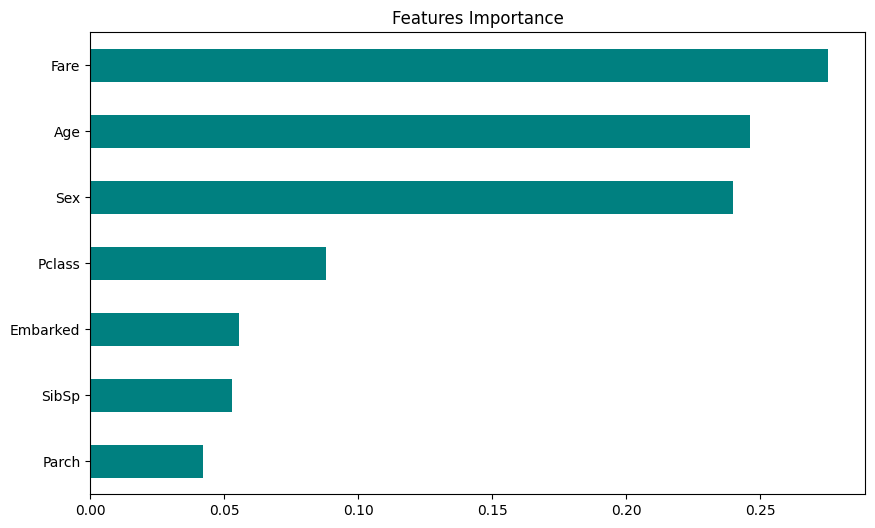

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. AIが算出した「重要度（%）」を取り出す
importances = model.feature_importances_

# 2. どの列がどの重要度なのか、名前とセットにする
# Seriesという「ラベル付きのリスト」を作ると便利です
feature_importances = pd.Series(importances, index = X_train.columns)

# 3. 見やすいようにランキング順（ソート）にして、棒グラフで表示！
plt.figure(figsize=(10,6))
# barh = 横向きの棒グラフ
feature_importances.sort_values().plot(kind='barh',color='teal')

#グラフのタイトル決定
plt.title('Features Importance')
plt.show()

#考察
#AIは運賃、年齢、性別を重く見たのか
#客室等級ではなくて運賃を選ぶのはなぜだろう？

Gem Py (🐍): 「論理的（Logical）に回答します。 Yukky様の疑問はもっともです。普通に考えれば、『等級』の方が偉そうですよね？

しかし、AI（決定木）にとっては違います。

Pclass (等級): 『大・中・小』の 3段階 しかありません。

Fare (運賃): 『$7.90』『$8.05』『$10.50』……と、数百通りの違い があります。

AIはこう考えたのです。 『同じ3等客室でも、$7（安い）の人 と $15（高い）の人 では、部屋の場所が違うかもしれない』 『運賃の方が、より細かく（Granular） その人の社会的地位や、部屋の位置を表している！』

つまり、『等級（大雑把なランク）』よりも『運賃（リアルな金額）』の方が、情報量（Information）が多かった。 だからAIは運賃をNo.1に選んだのです。」

ボーナスタイム
「自分の運命」

In [13]:
# 1. あなたの分身を作る（ここの数字を変えて遊んでね！）
my_data = pd.DataFrame({
    'Pclass': [1],     # 1=金持ち, 3=庶民
    'Sex': [0],        # 0=男性, 1=女性
    'Age': [30],       # あなたの年齢
    'SibSp': [0],      # 一緒に乗る兄弟・配偶者の数
    'Parch': [0],      # 一緒に乗る親・子供の数
    'Fare': [500.0],    # 運賃（3等平均=13, 1等平均=84, 超VIP=500）
    'Embarked': [0]    # 乗り場（0=S, 1=C, 2=Q）気にしなくてOK
})

# 2. AIに「僕、助かりますか？」と聞く
# predict_proba という命令を使うと、「助かる確率(%)」を教えてくれます
prediction = model.predict_proba(my_data)

# 結果を表示
survival_rate = prediction[0][1] * 100 # [1]が「生存」の確率
print(f"▼ あなたの生存確率予測 ▼")
print(f"運命の確率は... {survival_rate:.1f}% です！")

if survival_rate > 50:
    print("🎉 おめでとうございます！ 生還できる可能性が高いです！")
else:
    print("💀 残念ながら... 氷の海に沈む運命かもしれません...")

▼ あなたの生存確率予測 ▼
運命の確率は... 20.0% です！
💀 残念ながら... 氷の海に沈む運命かもしれません...


In [14]:
# 1. 「総当たり実験マシーン（GridSearchCV）」を呼び出す
from sklearn.model_selection import GridSearchCV

# 2. 実験したい設定のリストを作る（ここがレシピ！）
# n_estimators: 木の数（多いほうがいい？少ないほうがいい？）
# max_depth: 木の深さ（深すぎると考えすぎちゃうかも？）
param_grid = {
    'n_estimators': [1,10,25,50, 100, 200,300,400],
    'max_depth': [1,5, 10, 20, 30, 40, None]
}

# 3. 実験マシーンをセット！
# cv=5 は「5回ずつテストして平均点を取る（まぐれ当たり防止）」という意味です
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# 4. 実験開始！（少し時間がかかります）
print("🧪 ベストな設定を探しています...（数秒〜数十秒お待ちください）")
grid_search.fit(X_train, y_train)

# 5. 結果発表！
print("\n🎉 見つかりました！")
print(f"★ 最強の設定: {grid_search.best_params_}")
print(f"★ その時の最高スコア（訓練データ）: {grid_search.best_score_ * 100:.2f}%")

# 6. その最強AIを使って、改めてテスト（本番）してみる
best_model = grid_search.best_estimator_
final_accuracy = best_model.score(X_test, y_test)
print(f"\n🚀 最終テスト結果 (Day 5 Score): {final_accuracy * 100:.2f}%")

#考察
#木の本数は多く、木の深さは浅く、がAI的には良い設定
#深いほうが良さそうだけど、浅いほうが良いってなったのはなぜだろう
#-> 『過学習（Overfitting）』 という現象
# 深い木 (Depth=20): 教科書を 丸暗記 した学生です。 『3行目の単語はこれ！』と覚えているので、過去問（訓練データ）は満点ですが、見たことのない問題（テストデータ）には応用が利きません。
# 浅い木 (Depth=5): 要点だけを ざっくり理解 した学生です。 『だいたいこういう傾向がある』と覚えているので、新しい問題にも柔軟に対応できます。
#-> ランダムフォレストは、この 『ざっくり理解した学生（浅い木）』を200人（n_estimators=200）集めて多数決をとる 作戦が、一番強かった

🧪 ベストな設定を探しています...（数秒〜数十秒お待ちください）

🎉 見つかりました！
★ 最強の設定: {'max_depth': 5, 'n_estimators': 200}
★ その時の最高スコア（訓練データ）: 82.66%

🚀 最終テスト結果 (Day 5 Score): 83.58%


In [15]:
# 1. もう一度、あなたの分身（石油王ver）を作ります
my_data_revenge = pd.DataFrame({
    'Pclass': [1],     # 1等客室
    'Sex': [0],        # 男性
    'Age': [30],       # 30歳
    'SibSp': [0],
    'Parch': [0],
    'Fare': [500.0],   # 超高額運賃
    'Embarked': [0]
})

# 2. 進化したAI（best_model）に判定させる
# さっき作った「best_model」が、最強の設定を覚えています
prediction_revenge = best_model.predict_proba(my_data_revenge)

# 3. 結果発表！
survival_rate_revenge = prediction_revenge[0][1] * 100

print(f"▼ 進化したAIによる運命の判定 ▼")
print(f"前回の確率(78% AI): 42.0%")
print(f"今回の確率(82% AI): {survival_rate_revenge:.1f}%")

if survival_rate_revenge > 42:
    print("📈 上がりました！！ AIはあなたを見捨てなかった！")
elif survival_rate_revenge < 42:
    print("📉 下がりました... 賢いAIほど、現実は非情なようです...")
else:
    print("➡️ 変わりませんでした。運命は変えられない...？")

▼ 進化したAIによる運命の判定 ▼
前回の確率(78% AI): 42.0%
今回の確率(82% AI): 44.7%
📈 上がりました！！ AIはあなたを見捨てなかった！


Python界の革命児 『Streamlit（ストリームリット）』。 HTMLとかJavaScriptとか、難しいWebの知識は一切不要！ Pythonだけで、おしゃれなアプリが作れる魔法

仕組みはシンプルです。
1.   Pythonで書く: st.title("タイトル") と書く。
2.   Streamlitが翻訳: 自動的に綺麗なWebページ（HTML）に変換して表示する。



In [16]:
# 1. 魔法のツール「Streamlit」をインストール
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.8 MB/s eta 0:00:00


In [17]:
%%writefile app.py
# ↑ これを書くと、下の内容が「app.py」というファイルに保存されます

import streamlit as st

# 1. タイトルを表示
st.title("🚢 タイタニック生存予測アプリ")

# 2. テキストを表示
st.write("Day 6: Streamlitのテスト中だよ！")

# 3. 画像も出せる（ネット上の画像URL）
st.image("https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/RMS_Titanic_3.jpg/800px-RMS_Titanic_3.jpg")

Writing app.py


【アプリの起動手順】

1.   IPアドレスを確認: 下のコードを実行すると、数字（例: 34.123.45.67）が出ます。これをコピーしてください。

2.   アプリ起動: その下のコードを実行すると、URL が出ます。
3.   パスワード入力: URLをクリックした先の画面で、さっきの IPアドレス を貼り付けて『Submit』を押します。



In [18]:
# 手順1: あなたの今の「IPアドレス」を調べる（コピーしてね！）
print("▼ 下の数字をコピーしておいてね！ ▼")
!wget -q -O - ipv4.icanhazip.com

▼ 下の数字をコピーしておいてね！ ▼
xx.xxx.xxx.xx


In [19]:
# 手順2: アプリを起動する！（URLをクリックして、さっきの数字を入れてね）
# npx localtunnel というツールで、Colabの裏口を開けます
#!streamlit run app.py & npx localtunnel --port 8501
# 「-y」をつけて、勝手にインストールするようにしました！
!streamlit run app.py & npx -y localtunnel --port 8501

⠙⠹⠸

⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.221.224.48:8501

⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙your url is: https://fast-pans-stop.loca.lt
  Stopping...
^C


Gem Py (🐍): 「論理的（Logical）に手順を説明します。 今、AI（best_model）は、Pythonのメモリの中に浮いているだけの『記憶』です。 これをアプリで使うには、一度 『ファイル（.pkl）』 として保存し、アプリ側で読み込む必要があります。

やることは2つです。

1.   保存: ノートブック上で、AIをファイルに書き出す。
2.   実装: アプリのコード（app.py）を書き換えて、そのファイルを読み込ませる。

まずは 『AIをカプセルに入れて保存』 しましょう。」

In [20]:
# 1. AI保存用のライブラリを呼ぶ
import joblib

# 2. 育てたAI（best_model）を「titanic_model.pkl」という名前で保存する
# これで、AIが「ファイル」になります！
joblib.dump(best_model, 'titanic_model.pkl')

print("💾 AIの脳みそを保存しました！ アプリに組み込めます！")

💾 AIの脳みそを保存しました！ アプリに組み込めます！


In [21]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# 1. 保存したAI（脳みそ）を読み込む
# さっき保存したファイルを、アプリの中で復活させます
model = joblib.load('titanic_model.pkl')

# 2. 画面のデザインを作る
st.title("🚢 タイタニック生存予測AI")
st.write("あなたがもし乗船していたら...？ AIが運命を判定します！")

# --- ユーザーが入力する場所（サイドバー） ---
st.sidebar.header("👇 あなたの情報を入力してね")

# 性別（セレクトボックス）
sex = st.sidebar.radio("性別は？", ["Male (男性)", "Female (女性)"])
sex_val = 0 if "Male" in sex else 1 # AI用に0か1に変換

# 年齢（スライダー）
age = st.sidebar.slider("年齢は？", 0, 100, 30)

# 客室等級（セレクトボックス）
pclass = st.sidebar.selectbox("客室のランクは？", [1, 2, 3])
st.sidebar.write(f"※ 1等=超豪華, 3等=庶民")

# 運賃（スライダー）
fare = st.sidebar.slider("チケット代($)はいくら払う？", 0, 600, 50)

# --- 予測ボタン ---
if st.button("運命を占う！🔮"):
    # 1. 入力されたデータをAIが読める形にする
    # (今回使わないデータは0で埋めておきます)
    input_data = pd.DataFrame({
        'Pclass': [pclass],
        'Sex': [sex_val],
        'Age': [age],
        'SibSp': [0],
        'Parch': [0],
        'Fare': [fare],
        'Embarked': [0]
    })

    # 2. AIに予測させる！
    prediction = model.predict_proba(input_data)
    survival_rate = prediction[0][1] * 100

    # 3. 結果を派手に表示！
    st.write(f"### 運命の生存確率は... **{survival_rate:.1f}%** です！")

    if survival_rate > 50:
        st.success("🎉 おめでとうございます！ 生還できる可能性が高いです！")
        st.balloons() # 風船が飛ぶよ！
    else:
        st.error("💀 残念ながら... 厳しい運命が待っているかもしれません...")

Overwriting app.py


In [22]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# 1. AIを読み込む
model = joblib.load('titanic_model.pkl')

# --- ページ設定（ここを少し豪華に！） ---
st.set_page_config(
    page_title="タイタニックAI占い",
    page_icon="🚢",
    layout="wide" # 画面を広く使う設定！
)

st.title("🚢 タイタニック生存予測AI")
st.markdown("あなたがもし乗船していたら...？ AIが運命を判定します！")
st.markdown("---") # 区切り線

# --- 【重要】画面を「2つ」に分ける魔法！ ---
col1, col2 = st.columns(2)

# --- 右側 (col2) に入力画面を作る ---
with col2:
    st.header("👇 あなたの情報を入力")
    sex = st.radio("性別は？", ["Male (男性)", "Female (女性)"])
    sex_val = 0 if "Male" in sex else 1
    age = st.slider("年齢は？", 0, 100, 30)
    pclass = st.selectbox("客室のランクは？", [1, 2, 3])
    st.caption("※ 1等=超豪華, 3等=庶民")
    fare = st.slider("チケット代($)は？", 0, 600, 50)

    # 予測ボタン（右側に置く）
    predict_btn = st.button("運命を占う！🔮", type="primary") # ボタンを少し目立たせる

# --- 左側 (col1) に予測結果を出す ---
with col1:
    st.header("🤖 AIの判定結果")

    # ボタンが押されるか、または初回起動時に計算する
    input_data = pd.DataFrame({
        'Pclass': [pclass], 'Sex': [sex_val], 'Age': [age],
        'SibSp': [0], 'Parch': [0], 'Fare': [fare], 'Embarked': [0]
    })
    prediction = model.predict_proba(input_data)
    survival_rate = prediction[0][1] * 100

    # 結果を大きく表示！
    st.metric(label="生存確率", value=f"{survival_rate:.1f}%")

    if survival_rate > 50:
        st.success("🎉 おめでとうございます！ 生還の可能性が高いです！")
        # ボタンが押された時だけ風船を飛ばす
        if predict_btn: st.balloons()
    else:
        st.error("💀 残念ながら... 厳しい運命が待っているかもしれません...")

Overwriting app.py
